# Model Errors

In this notebook we compare different versions of the Heston MC model, and calculate model errors vs closed form solution.

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from qablet_contracts.eq.vanilla import Option
from qablet_contracts.timetable import py_to_ts
from src.qablet_utils import option_prices
from src.models.aes import HestonAESMC
from src.models.basic import HestonMCModel
from qablet.heston.mc import (
    HestonMCModel as HestonMCModelOpt,
)  # Optimized version of Heston from qablet package
from src.models.closed import price_vanilla_call
import matplotlib.pyplot as plt
import time

## Create Dataset
Create the dataset, with MC params, discounts and fwds as required by the [Dataset API](https://qablet-academy.github.io/intro/dataset/)

In [ ]:
# Rate Curve
times = np.array([0.0, 5.0])
rates = np.array([0.1, 0.1])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

# Forward Curve
ticker = "EQ"
spot = 100.0
div_rate = 0.0
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

pricing_datetime = datetime(2023, 12, 31)
dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(pricing_datetime).value,
    "ASSETS": {"USD": discount_data, ticker: fwd_data},
    "MC": {
        "PATHS": 2_500,
        "TIMESTEP": 1 / 1000,
        "SEED": 1,
    },
    "HESTON": {
        "ASSET": ticker,
        "INITIAL_VAR": 0.04,
        "LONG_VAR": 0.04,
        "VOL_OF_VAR": 1.0,
        "MEANREV": 0.5,
        "CORRELATION": -0.9,
    },
}

## Calculate Single Option Prices

Define a [Vanilla Option](https://qablet.github.io/qablet-contracts/examples/equity_vanilla/) and calculate price.

In [ ]:
# Create Contract
strike = 100
ticker = "EQ"
timetable = Option(
    "USD", ticker, strike=strike, maturity=datetime(2024, 12, 31), is_call=True
).timetable()
print(timetable["events"].to_pandas())

  track                      time op  quantity unit
0       2024-12-31 00:00:00+00:00  >       0.0  USD
1       2024-12-31 00:00:00+00:00  +    -100.0  USD
2       2024-12-31 00:00:00+00:00  +       1.0   EQ


In [ ]:
# Create models and price
models = {
    "Basic": HestonMCModel(),
    "AES": HestonAESMC(),
    "Optimized": HestonMCModelOpt(),
}

for model_name, model in models.items():
    price, _ = model.price(timetable, dataset)
    print(f"{model_name:20s}: {price:11.6f}")

Basic               :   12.408991
AES                 :   12.100248
Optimized           :   12.278145


In [ ]:
# Closed form price
closed_price, _ = price_vanilla_call(
    strike,
    1.0,
    ticker,
    dataset,
)
print(f"closed_price: {closed_price:11.6f}")

closed_price:   12.331475


## Model Errors vs Closed Form

In [ ]:
expirations = [
    datetime(2024, 3, 31),
    datetime(2024, 6, 30),
    datetime(2024, 12, 31),
]
strikes = np.array([0.8, 0.9, 1.0, 1.1, 1.2]) * spot
is_call = True

### Get Closed Form prices

In [ ]:
closed_price_df = pd.DataFrame.from_dict({"Strike": strikes})
for i, exp in enumerate(expirations):
    prc_ts = dataset["PRICING_TS"]
    # Get Time in years from the millisecond timestamps
    T = (py_to_ts(exp).value - prc_ts) / (365.25 * 24 * 3600 * 1e3)
    closed_prices = []
    for strike in strikes:
        closed_price, _ = price_vanilla_call(
            strike,
            T,
            ticker,
            dataset,
        )
        closed_prices.append(closed_price)

    exp_str = exp.strftime("%Y-%m-%d")
    closed_price_df[exp_str] = closed_prices

print(closed_price_df)

   Strike  2024-03-31  2024-06-30  2024-12-31
0    80.0   22.367712   24.774291   28.959679
1    90.0   13.245177   15.940640   20.524025
2   100.0    4.892852    7.544810   12.350271
3   110.0    0.127474    0.851502    4.776674
4   120.0    0.001781    0.039581    0.422797


In [ ]:
for model_name, model in models.items():
    prices_df = option_prices(
        ticker, expirations, strikes, is_call, model, dataset
    )
    print(f"\n{model_name}")
    print(prices_df - closed_price_df)


Basic
   Strike  2024-03-31  2024-06-30  2024-12-31
0     0.0   -0.104278    0.053314    0.163472
1     0.0   -0.100393    0.008060    0.134067
2     0.0   -0.039737    0.014014    0.101700
3     0.0   -0.011604    0.023235    0.077360
4     0.0   -0.000622   -0.011075    0.005107

AES
   Strike  2024-03-31  2024-06-30  2024-12-31
0     0.0   -0.256676   -0.427763   -0.431886
1     0.0   -0.211879   -0.315720   -0.335467
2     0.0   -0.154231   -0.209224   -0.240877
3     0.0   -0.029889   -0.083290   -0.123308
4     0.0   -0.001781   -0.017288   -0.027943

Optimized
   Strike  2024-03-31  2024-06-30  2024-12-31
0     0.0    0.081094   -0.058282   -0.184509
1     0.0    0.087401   -0.017940   -0.122678
2     0.0    0.058316    0.047434   -0.068807
3     0.0    0.029075    0.071899    0.002644
4     0.0    0.001156    0.007049    0.010707


# Mean Square Errors
Run simulation with different seeds, and calculate the MSE.

Basic               :    0.015961 mse 0.16 sec/call
AES                 :    0.017485 mse 0.29 sec/call
Optimized           :    0.032093 mse 0.08 sec/call


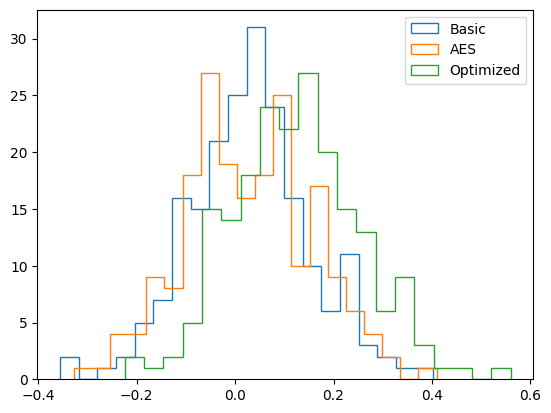

In [ ]:
# Closed form price
strike = 100
closed_price, _ = price_vanilla_call(
    strike,
    1.0,
    ticker,
    dataset,
)
iterations = 200
errors = {}
for model_name, model in models.items():
    errors[model_name] = []
    start_time = time.time()
    for seed in range(1, iterations):
        dataset["MC"]["SEED"] = seed
        price, _ = model.price(timetable, dataset)
        errors[model_name].append(price - closed_price)

    elapsed_time = (time.time() - start_time) / iterations
    mse = np.square(errors[model_name]).mean()
    print(f"{model_name:20s}: {mse:11.6f} mse {elapsed_time:.2f} sec/call")

    plt.hist(errors[model_name], bins=20, histtype="step", label=model_name)
plt.legend()
plt.show()